# Outlier detection using the GESD algorithm

Erroneous data points present a problem in engineering analysis, and it is desirable to identify outliers for review. Keep in mind that an outlier may represent an unexpected (but real) result, and should not be automatically removed from the dataset. However, when the point results from in error in the measurement and/or data collection process, it should be removed or replaced to preserve the data quality.

As an element of the Engineering Statistics Handbook, NIST has published a description of the [Generalized ESD Test for Outliers](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm). Compared to other methods, this algorithm has the advantage that the number of outliers does not need to be specified in advance. NIST provides a description of the algorithm, sample data from literature (Rosner, 1983) and sample R code.

In this notebook, we will explore the NIST sample data and demonstrate an implementation of this outlier detection algorithm in the Python programming language.

**References**

Rosner, Bernard (May 1983), Percentage Points for a Generalized ESD Many-Outlier Procedure,Technometrics, 25(2), pp. 165-172.

In [175]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')


## 1. Review of sample data

Sample data, from [Rosner, 1983](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm) are entered as a `numpy.ndarray`. As shown in the Engineering Statistics Handbook, data is first visualized in a normal probability plot.

Text(0.5, 1.0, 'Normal Probability Plot')

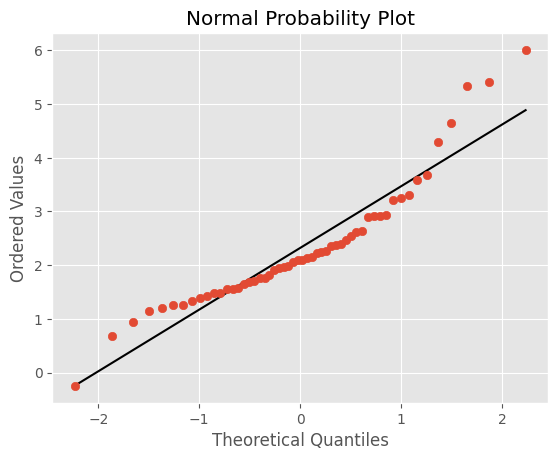

In [168]:
# sample data from https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm
y = np.array([
    -0.25, 0.68, 0.94, 1.15, 1.20, 1.26, 1.26,
     1.34, 1.38, 1.43, 1.49, 1.49, 1.55, 1.56,
     1.58, 1.65, 1.69, 1.70, 1.76, 1.77, 1.81,
     1.91, 1.94, 1.96, 1.99, 2.06, 2.09, 2.10,
     2.14, 2.15, 2.23, 2.24, 2.26, 2.35, 2.37,
     2.40, 2.47, 2.54, 2.62, 2.64, 2.90, 2.92,
     2.92, 2.93, 3.21, 3.26, 3.30, 3.59, 3.68,
     4.30, 4.64, 5.34, 5.42, 6.01
])

# compute the theoretical quantiles
(plot_x, plot_y), (m, b, r) = scipy.stats.probplot(y, dist='norm')

# generate the custom plot
fig, ax = plt.subplots()
ax.plot(plot_x, plot_x*m+b, color='black')
ax.scatter(plot_x, plot_y, marker='o', zorder=10)

ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Ordered Values')
ax.set_title('Normal Probability Plot')


## 2. Definition of `gesd()`

### Algorithm for calculating the test statistic, $R_i$

1. Let $y \in \mathbb{R}^n$ represent the vector of all observations
2. Let $N=$ maximum number of outliers allowed (user defined)
3. For $i \in {1,2,...,N}$:
        
    a. Compute the test residuals $r_i=\frac{|y'_i-\bar{y}'_i|}{s_i}$
    
    b. Calculate the test statistic $R_i=\max \left[ r_i \right]$

    c. Find the observation, $y'_{i,max}$ corresponding to the maximum $R_i$

    d. Update $y'_{i+1}=y'_i \backslash y'_{i,max}$ and repeat



#### Critical Value, $\lambda_i$

1. Calculate the p-value: $p=1-\frac{\alpha}{2 \left(n-i+1\right)}$

2. Calculate the t-score: $t=ppf_t \left(p, \nu=n-i-1 \right)$

3. The critical value is then: $\lambda_i=\frac{\left(n-i\right)t}{\sqrt{\left(n-i-1+t^2\right)\left(n-i+1\right)}}$


In [97]:
def gesd(y: np.ndarray, max_outliers: int, alpha=0.05, verbose=False):
        
    n = len(y)

    # must have at least 3 good datapoints
    max_outliers = min(n-3, max_outliers)
    
    test_statistics = np.zeros(max_outliers)
    critical_values = np.zeros(max_outliers)
    outlier_values = np.zeros(max_outliers)

    yi = y.copy()

    for i in range(1, max_outliers+1):

        # calculate the critical value
        p = 1 - alpha / (2*(n-i+1))
        t = scipy.stats.t.ppf(p, df=n-i-1)
        
        critical_values[i-1] = (n-i)*t / np.sqrt((n-i-1+t**2)*(n-i+1))
        
        # calculate the test statistic
        r = np.abs(yi-yi.mean())/yi.std(ddof=1)

        test_statistics[i-1] = r.max()

        # find the outlier value and remove
        sorted_y = yi[r.argsort()]
        outlier_values[i-1] = sorted_y[-1]
        yi = sorted_y[:-1]

    # hide options where the test statistics <= critical value
    possible_outlier_count = np.select([test_statistics>critical_values], 
                                       [test_statistics], 
                                       0)
    
    # find the max test statistic from the remaining values
    n_outliers = np.argmax(possible_outlier_count)+1

    if verbose:

        # print out a pd.DataFrame containing the statistics table
        df = pd.DataFrame({'outliers': np.arange(1, max_outliers+1),
                           'test_statistic': test_statistics,
                           'critical_value': critical_values,
                           'outlier_value': outlier_values})        

        df['selected'] = df['outliers'].apply(lambda x: '*' if x==n_outliers else '')  
        df.set_index('outliers', inplace=True)

        print(df)

    # return the values identified as outliers
    return outlier_values[:n_outliers]


## Use `gesd()` to identify outliers and visualize

In [177]:
# execute the gesd() function to generate the table presented by NIST
outlier_values = gesd(y, 10, verbose=True)


          test_statistic  critical_value  outlier_value selected
outliers                                                        
1               3.118906        3.158794           6.01         
2               2.942973        3.151430           5.42         
3               3.179424        3.143890           5.34        *
4               2.810181        3.136165           4.64         
5               2.815580        3.128247          -0.25         
6               2.848172        3.120128           4.30         
7               2.279327        3.111796           3.68         
8               2.310366        3.103243           3.59         
9               2.101581        3.094456           0.68         
10              2.067178        3.085425           3.30         


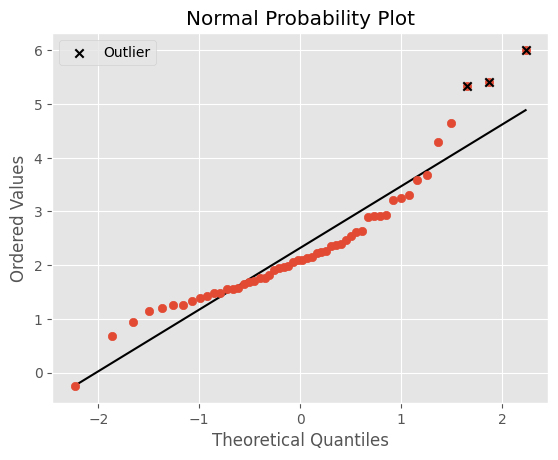

In [174]:
# show the results on the normal probability plot

# compute the theoretical quantiles
(plot_x, plot_y), (m, b, r) = scipy.stats.probplot(y, dist='norm')

# generate the custom plot
fig, ax = plt.subplots()
ax.plot(plot_x, plot_x*m+b, color='black')
ax.scatter(plot_x, plot_y, marker='o', zorder=10)

# mark the identified outliers
outlier_x = np.zeros(len(outlier_values))

for i, o in enumerate(outlier_values):
    outlier_x[i] = plot_x[np.argwhere(plot_y==o)]
    
    
ax.scatter(outlier_x, outlier_values, 
            marker='x', color='black', zorder=100,
            label='Outlier')

ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Ordered Values')
ax.set_title('Normal Probability Plot')
ax.legend()
